### Домашнее задание №3 к лекции «Функции и работа с данными»

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import os

#### Задание 1
Напишите функцию, которая классифицирует фильмы из материалов занятия по следующим правилам:
- оценка 2 и меньше - низкий рейтинг
- оценка 4 и меньше - средний рейтинг
- оценка 4.5 и 5 - высокий рейтинг

Результат классификации запишите в столбец class

In [2]:
task_1_files = [file for file in os.listdir('ml-latest') if '.csv' in file]
# распакованный архив с этого сайта кладем в папку с ноутбуком
task_1_files

['links.csv', 'tags.csv', 'ratings.csv', 'keywords.csv', 'movies.csv']

In [3]:
ratings = pd.read_csv(os.getcwd() + '/ml-latest/' + task_1_files[2])

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
%%time
ratings['class_1'] = ratings['rating'].apply(
    lambda x: 'низкий рейтинг' if x <= 2 else('средний рейтинг' if x <= 4 else'высокий рейтинг'))

CPU times: user 33.5 ms, sys: 2.68 ms, total: 36.1 ms
Wall time: 33.8 ms


In [6]:
ratings.groupby('class_1').agg({'rating': 'unique'})

,rating
class_1,
высокий рейтинг,"[5.0, 4.5]"
низкий рейтинг,"[2.0, 1.0, 1.5, 0.5]"
средний рейтинг,"[2.5, 3.0, 4.0, 3.5]"


In [7]:
def get_class(row):
    if row.rating <= 2:
        return 'низкий рейтинг'
    elif row.rating <= 4:
        return 'средний рейтинг'
    else:
        return 'высокий рейтинг'

In [8]:
%%time
ratings['class_2'] = ratings.apply(get_class, axis=1)

CPU times: user 1.53 s, sys: 19.2 ms, total: 1.55 s
Wall time: 1.55 s


In [9]:
ratings.groupby('class_2').agg({'rating': 'unique'})

,rating
class_2,
высокий рейтинг,"[5.0, 4.5]"
низкий рейтинг,"[2.0, 1.0, 1.5, 0.5]"
средний рейтинг,"[2.5, 3.0, 4.0, 3.5]"


Результат одинаков. Первый вариант быстрее, что объясняется только тем что метод `apply` обращается к конкретному столбцу, а второй ко всей строке

#### Задание 2
Используем файл keywords.csv.

Необходимо написать гео-классификатор, который каждой строке сможет выставить географическую принадлежность определенному региону. Т. е. если поисковый запрос содержит название города региона, то в столбце ‘region’ пишется название этого региона. Если поисковый запрос не содержит названия города, то ставим ‘undefined’.  
Результат классификации запишите в отдельный столбец region.

In [10]:
geo_data = {
'Центр': ['москва', 'тула', 'ярославль'],
'Северо-Запад': ['петербург', 'псков', 'мурманск'],
'Дальний Восток': ['владивосток', 'сахалин', 'хабаровск']
}

In [11]:
keywords = pd.read_csv(os.getcwd() + '/ml-latest/' + task_1_files[3])

In [12]:
def get_region(keyword):
    for region,cities in geo_data.items():
        for city in cities:
            if city in keyword:
                return region
    return 'undefined'

In [13]:
keywords['region'] = keywords['keyword'].apply(get_region)

In [14]:
keywords.groupby('region').agg({'keyword': 'unique'})

,keyword
region,
undefined,"[вк, одноклассники, порно, ютуб, вконтакте, од..."
Дальний Восток,"[фарпост владивосток, дром хабаровск, дром вла..."
Северо-Запад,"[авито ру санкт петербург, погода в санкт пете..."
Центр,"[авито москва, авито ярославль, москва, гисмет..."


Формула вроде бы отработала правильно. Проверим сколько ключевых слов попало в __undefined__

In [15]:
len(keywords.groupby('region').agg({'keyword': 'unique'}).loc['undefined', 'keyword'])

99253

Из 100000 слов 99253. Выведем датафрейм только с ключевыми словами где есть города

In [16]:
keywords[keywords['keyword'].str.contains('|'.join(reduce(lambda x,y: x + y, list(geo_data.values()))), case=False)]

,keyword,shows,region
127,авито москва,979292,Центр
370,авито ру санкт петербург,425134,Северо-Запад
564,погода в санкт петербурге,292489,Северо-Запад
849,авито ярославль,209581,Центр
1063,фарпост владивосток,176951,Дальний Восток
...,...,...,...
99590,авито ярославль автомобили с пробегом,3673,Центр
99634,северпост новости мурманской области,3606,Северо-Запад
99808,полармед мурманск запись на прием,3719,Северо-Запад
99890,яндекс метро москва,4548,Центр


In [17]:
len(keywords.groupby('region').agg({'keyword': 'unique'}).loc['undefined', 'keyword']) + \
keywords[keywords['keyword'].str.contains('|'.join(reduce(lambda x,y: x + y, list(geo_data.values()))), case=False)].shape[0] == \
keywords.shape[0]

True

Все сматчилось корректно

#### Задание 3
Есть мнение, что “раньше снимали настоящее кино, не то что сейчас”. Ваша задача проверить это утверждение, используя файлы с рейтингами фильмов из прошлого домашнего занятия (файл movies.csv и ratings.csv из базы grouplens.org.../movielens). Т. е. проверить верно ли, что с ростом года выпуска фильма его средний рейтинг становится ниже.

При этом мы не будем затрагивать субьективные факторы выставления этих рейтингов, а пройдемся по следующему алгоритму:

В переменную years запишите список из всех годов с 1950 по 2010.

Напишите функцию production_year, которая каждой строке из названия фильма выставляет год выпуска. Не все названия фильмов содержат год выпуска в одинаковом формате, поэтому используйте следующий алгоритм:

для каждой строки пройдите по всем годам списка years
если номер года присутствует в названии фильма, то функция возвращает этот год как год выпуска
если ни один из номеров года списка years не встретился в названии фильма, то возвращается 1900 год
Запишите год выпуска фильма по алгоритму пункта 2 в новый столбец ‘year’

Посчитайте средний рейтинг всех фильмов для каждого значения столбца ‘year’ и отсортируйте результат по убыванию рейтинга

P/S/ все файлы находятся в архиве «дополнительные файлы к лекции и дз»

In [18]:
movies = pd.read_csv(os.getcwd() + '/ml-latest/' + task_1_files[4])
ratings = pd.read_csv(os.getcwd() + '/ml-latest/' + task_1_files[2])

In [19]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [21]:
def production_year(title):
    for i in list(range(1950,2010)):
        if str(i) in title:
            return i
    return 1900

In [22]:
movies['year'] = movies['title'].apply(production_year)

In [23]:
movies.set_index('movieId', inplace=True)

In [24]:
movies.sample(10)

,title,genres,year
movieId,,,
1168,Bad Moon (1996),Action|Adventure|Horror,1996
3891,Turn It Up (2000),Crime|Drama,2000
71180,Padre padrone (1977),Drama,1977
130580,The Disappearance of Eleanor Rigby: Her (2013),Drama,1900
866,Bound (1996),Crime|Drama|Romance|Thriller,1996
104457,You're Next (2011),Horror|Thriller,1900
2525,Alligator (1980),Action|Horror|Sci-Fi,1980
89753,Tinker Tailor Soldier Spy (2011),Drama|Film-Noir|Thriller,1900
142536,Burnt (2015),Drama,1900


Годы отразились согласно задуманному

В таблице __ratings__ определим средний рейтинг по каждому __movieId__. Полученный результат присоединим к таблице __movies__ по индексу __movieId__. после чего сгруппируем полученный датафрейм по годам и выведем средний рейтинг по году

In [25]:
result = movies.merge(
    ratings.groupby('movieId').agg({'rating':'mean'}), 
    how='left', left_index=True, right_index=True
).groupby('year').agg({'rating':'mean', 'title': 'count'}).loc[1950:2010,]

In [26]:
result.sort_values(by='rating', ascending=False)

,rating,title
year,,
1951,3.906653,23
1952,3.802318,27
1962,3.772962,41
1953,3.738878,36
1957,3.693322,41
1973,3.688212,51
1971,3.643227,56
1969,3.604509,40
1972,3.585295,48


<AxesSubplot:xlabel='year'>

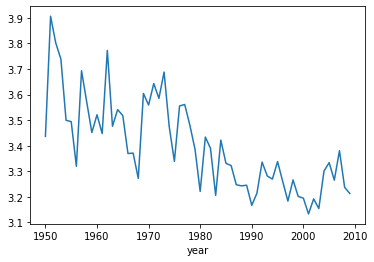

In [27]:
result.rating.plot()

<AxesSubplot:xlabel='year'>

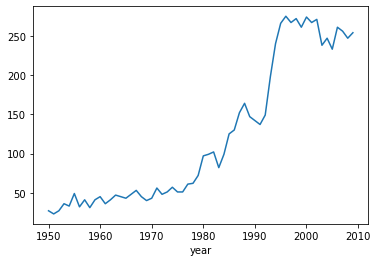

In [28]:
result.title.plot()

Похоже с годами средние рейтинги фильмов уменьшаются. Но с другой стороны и фильмов выпускается больше, плюс в данный архив могут заноситься заведомо удачные старые фильмы.